In [1]:
# try to import library, if it is not installed it will be downloaded (required to run code on Google Colab)
import os
try:
  import autoscattering
except:
  if not os.path.isdir('autoscatter'):
    !git clone https://github.com/jlandgr/autoscatter.git
    !mv autoscatter/autoscattering .

In [2]:
import sympy as sp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import autoscattering.architecture_optimizer as arch_opt
import autoscattering.constraints as msc
import autoscattering.symbolic as sym

A directional coupler has two input (or more) input ports. The summed up signal from the inputs is scattered towards the output port.
Furthermore, we demand, that there is no scattering from the potentially noisy output to the input ports. This corresponds to the scattering matrix:

$S_\mathrm{target}=\begin{pmatrix}0&0&0\\ 0&0&0\\ t&t&0 \end{pmatrix}$

$t$ is a transmission rate and its value is left open for optimisation

In [3]:
t = sp.Symbol('t', real=True) # transmission rate
S_target = sp.Matrix([[0,0,0],[0,0,0],[t,t,0]])

For a new scattering behaviour it is not clear how many auxiliary modes are required to realise the requested behaviour. 
You can find the minimum number of auxiliary modes automatically by using:

optimizer = arch_opt.find_minimum_number_auxiliary_modes(S_target=S_target)

The cells below show didactically how one can find the minimum number of auxiliary modes.

Let's start with zero auxiliary modes.

In [4]:
optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=0,
)

Exception: fully connected graph is invalid, interrupting

This does not work. Let's increase the number of auxiliary modes until we find the minimum number of auxiliary modes.

In [5]:


# You can also use the  instead of executing this cell You can use:
# optimizer = arch_opt.find_minimum_number_auxiliary_modes(S_target=S_target, start_value=0, max_value=5)

for num_auxiliary_modes in range(0, 5):
    print('try %i auxiliary modes'%num_auxiliary_modes)
    try:
        optimizer = arch_opt.Architecture_Optimizer(
            S_target=S_target,
            num_auxiliary_modes=num_auxiliary_modes,
        )
        print('success: %i is the number of required auxiliary modes'%num_auxiliary_modes)
        break
    except:
        print('%i auxiliary modes are not suifficient'%num_auxiliary_modes)

try 0 auxiliary modes
0 auxiliary modes are not suifficient
try 1 auxiliary modes
1 auxiliary modes are not suifficient
try 2 auxiliary modes
fully connected graph is a valid graph
success: 2 is the number of required auxiliary modes


Still not working. Let's try two auxiliary modes

This works! Now, we can prune the fully connected graph to find the irreducible graphs. This might take a while (~25min)

In [6]:
irreducible_graphs = optimizer.perform_depth_first_search()

prepare list of all possible graphs


1889568it [00:03, 510423.82it/s]


1889568 graphs identified
start depth-first search
test all graphs with 25 degrees of freedom:


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


test all graphs with 24 degrees of freedom:


100%|██████████| 15/15 [00:00<00:00, 21.70it/s]


test all graphs with 23 degrees of freedom:


100%|██████████| 101/101 [00:03<00:00, 25.89it/s]


test all graphs with 22 degrees of freedom:


100%|██████████| 411/411 [00:16<00:00, 25.25it/s]


test all graphs with 21 degrees of freedom:


100%|██████████| 1335/1335 [00:48<00:00, 27.64it/s]


test all graphs with 20 degrees of freedom:


100%|██████████| 2958/2958 [01:49<00:00, 27.10it/s]


test all graphs with 19 degrees of freedom:


100%|██████████| 6384/6384 [03:57<00:00, 26.90it/s]


test all graphs with 18 degrees of freedom:


100%|██████████| 10202/10202 [05:55<00:00, 28.69it/s]


test all graphs with 17 degrees of freedom:


100%|██████████| 11169/11169 [03:58<00:00, 46.76it/s] 


test all graphs with 16 degrees of freedom:


100%|██████████| 7698/7698 [02:49<00:00, 45.53it/s] 


test all graphs with 15 degrees of freedom:


100%|██████████| 3188/3188 [01:29<00:00, 35.82it/s] 


test all graphs with 14 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 13 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 12 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 11 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 10 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 9 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 8 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 7 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 6 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 5 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 4 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 3 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 2 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 1 degrees of freedom:


0it [00:00, ?it/s]


test all graphs with 0 degrees of freedom:


0it [00:00, ?it/s]


optimisation finished, list of irreducible graphs has 400 elements


Compare our optimisation (orange area) to a brute force search (gray area)

Even though our optimisation only tests around $1.3\times 10^4$ graphs we have found all valid graphs (namely all extensions of the graphs in the irreducible_graphs list)

number of tested graphs (orange area): 13597


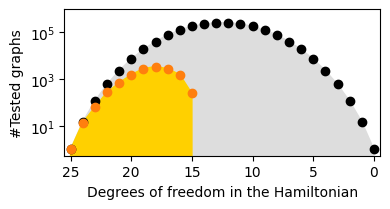

In [12]:
complexities, total_counts = np.unique(optimizer.complexity_levels, return_counts=True)
num_degrees_of_freedom_tested = optimizer.tested_complexities
total_counts_tested = optimizer.num_tested_graphs

fig, ax = plt.subplots(figsize=(4,2.2))
ax.semilogy(complexities, total_counts, ls='None', marker='o', color='black')
ax.semilogy(num_degrees_of_freedom_tested, total_counts_tested, ls='None', marker='o', color='C1')
ax.fill_between(complexities, total_counts, interpolate=True, color='#DDDDDD')
ax.fill_between(num_degrees_of_freedom_tested, total_counts_tested, interpolate=True, color='#ffd000')

ax.set_xlim(25.5, -0.5)
ax.set_ylim(None, 10**6)
ax.set_yticks([10,1000,100000])
ax.set_xlabel('Degrees of freedom in the Hamiltonian')
ax.set_ylabel('#Tested graphs')
fig.tight_layout()
# print('number of possible graphs (gray area): %i'%optimizer.num_possible_graphs)
print('number of tested graphs (orange area): %i'%np.sum(total_counts_tested))

Characterise all found solutions

In [13]:
import autoscattering.architecture as arch
irreducible_graphs_info = arch.characterize_architectures(optimizer.valid_combinations)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:01<00:00, 271.55it/s]


Select and plot those graphs which have the lowest number of couplings

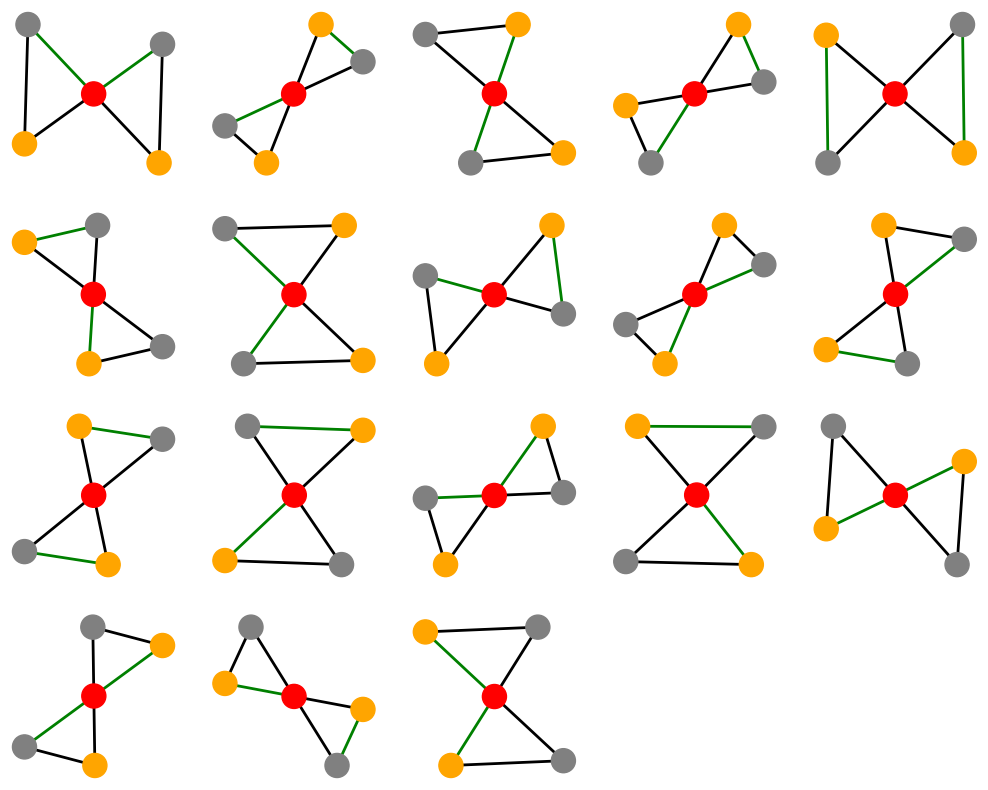

In [14]:
num_min_couplings = np.min(irreducible_graphs_info['num_couplings'])
idxs_min_pumps = np.where(irreducible_graphs_info['num_couplings'] == num_min_couplings)[0]
irreducible_graphs_min_couplings = irreducible_graphs[idxs_min_pumps]

node_colors = ['orange', 'orange', 'red', 'gray', 'gray'] # the input modes are orange, the output mode is red, the auxiliary modes are gray
msc.plot_list_of_graphs(irreducible_graphs_min_couplings, node_colors=node_colors)

Select those graphs which require the smallest number of parametric pumps. Of all of them: Subselect those with the smallest number of couplings

100%|██████████| 72/72 [00:00<00:00, 262.09it/s]


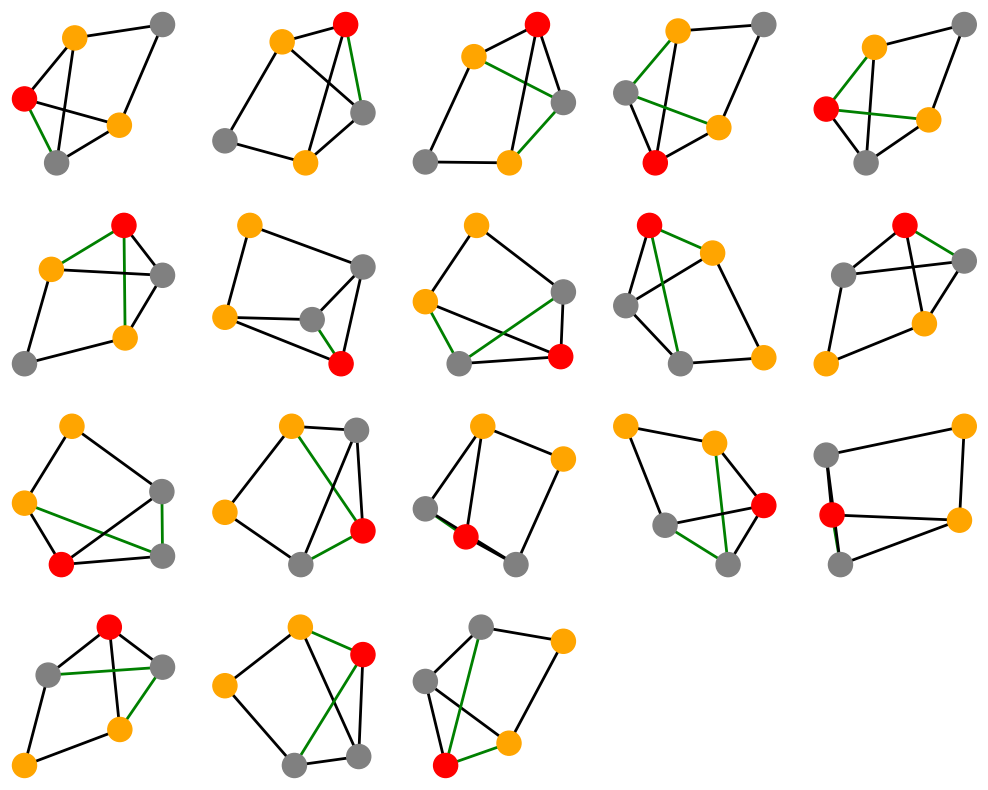

In [15]:
# Select the graphs with the smallest number of parametric pumps
min_parametric_pumps = np.min(irreducible_graphs_info['minimal_number_of_pumps'])
idxs_min_pumps = np.where(irreducible_graphs_info['minimal_number_of_pumps'] == min_parametric_pumps)[0]

# Subselect those with the smallest number of couplings
irreducible_graphs_min_parametric_pumps = np.array(irreducible_graphs)[idxs_min_pumps]
infos_subselection = arch.characterize_architectures(irreducible_graphs_min_parametric_pumps)
idxs_min_couplings = np.where(infos_subselection['num_couplings'] == np.min(infos_subselection['num_couplings']))[0]
irreducible_graphs_min_pumps_min_couplings = irreducible_graphs_min_parametric_pumps[idxs_min_couplings]

node_colors = ['orange', 'orange', 'red', 'gray', 'gray'] # the input modes are orange, the output mode is red, the auxiliary modes are gray
msc.plot_list_of_graphs(irreducible_graphs_min_pumps_min_couplings, node_colors=node_colors)

Given a certain graph, you can identify the minimum number of active couplings and the associated frequency classes using the function arch.find_min_number_of_pumps, see section VIII in our paper for more details.
Modes of the same class are operated at the same frequency, otherwise they are not. Below, the class is depicted by an integer value.

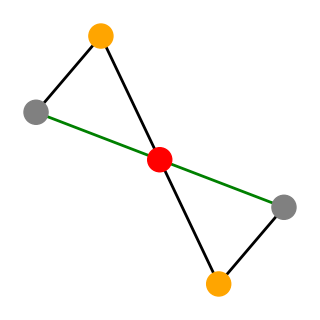

This graphs requires at least 4 parametric couplings
Here are all possible frequency class assignments such that this minimum number of parametric pumps is achieved:
[0 0 0 1 1]
[0 0 0 1 2]
[0 0 1 0 0]
[0 1 0 1 1]
[0 1 0 1 2]
[0 1 1 0 0]
[0 1 1 2 0]
[0 1 2 1 0]


In [16]:
graph_to_test = [0,0,1,0,1,0,1,1,0,0,2,2,0,0,0]
plt.figure(figsize=(3,3))
msc.plot_graph(triu_matrix=graph_to_test, node_colors=node_colors)
plt.show()
min_active_couplings, possible_frequency_classes = arch.find_min_number_of_pumps(graph_to_test)
print('This graphs requires at least %i parametric couplings'%min_active_couplings)
print('Here are all possible frequency class assignments such that this minimum number of parametric pumps is achieved:')
for assignment in possible_frequency_classes:
    print(assignment)